In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file {name}'.format(name=fn))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file kaggle.json


In [3]:
!ls /root/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d anefiamutiaraatha/dataset-tanaman-herbal

100% 3.34G/3.35G [00:28<00:00, 164MB/s]
100% 3.35G/3.35G [00:28<00:00, 126MB/s]


In [5]:
!unzip dataset-tanaman-herbal.zip

Archive:  dataset-tanaman-herbal.zip
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (100).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (81).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (82).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (83).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (84).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (85).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (86).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (87).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (88).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (89).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (90).JPG  
  inf

In [20]:
#Data Preprocessing
import matplotlib.image as mping
import numpy as np
import matplotlib.pyplot as plt

#Deep Learning
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Add
from keras.layers import Activation, Dropout, BatchNormalization, Flatten
from keras.layers import Dense, AvgPool2D, MaxPool2D, Input, ReLU, GlobalAvgPool2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

In [7]:
trainDir = "/content/DATASET TANAMAN HERBAL/Data Training/"
validationDir = "/content/DATASET TANAMAN HERBAL/Data Testing/"

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)
train_generator = train_datagen.flow_from_directory(directory=trainDir,
                                                    batch_size=32, 
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    shuffle=True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(directory=validationDir,
                                                        batch_size=32, 
                                                        class_mode="categorical",
                                                        target_size=(224, 224),               
                                                        color_mode="rgb")

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [26]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainDir,
    batch_size=32,
    image_size=(224,224),
    shuffle=True
)

Found 800 files belonging to 10 classes.


In [27]:
class_names = train_dataset.class_names

print(class_names)

['Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Lidah Buaya', 'Teh Hijau']


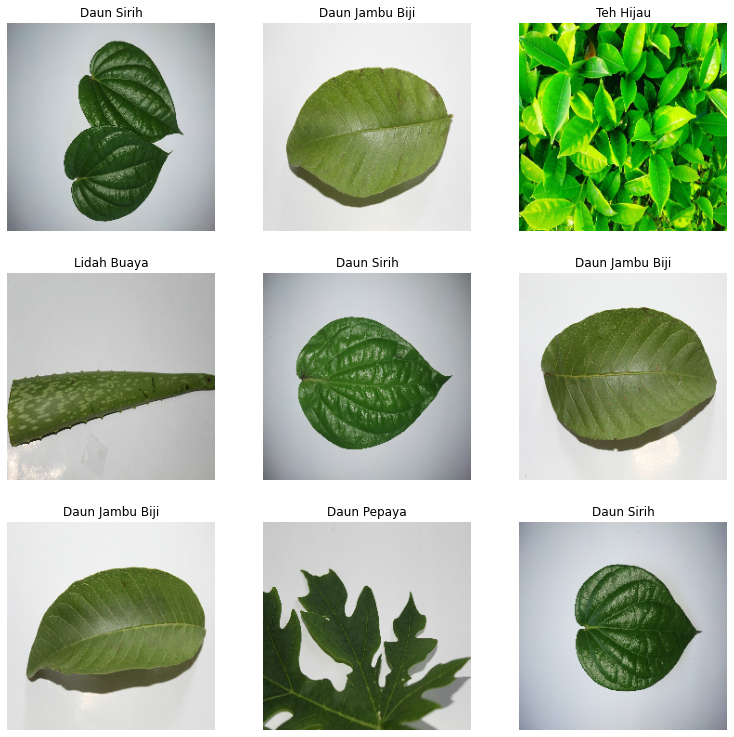

In [28]:
plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
IMG_SHAPE = (224, 224, 3)
base_model = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [10]:
base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
                             base_model,
                             keras.layers.GlobalAveragePooling2D(),
                             keras.layers.Dense(10, activation='softmax')
])

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [15]:
history = model.fit(train_generator, 
                    epochs=10, 
                    steps_per_epoch=25, 
                    validation_data=validation_generator, 
                    validation_steps=6,
                    verbose=1)

Epoch 1/10
25/25 [==============================] - 392s 16s/step - loss: 1.7576 - accuracy: 0.6225 - val_loss: 1.8189 - val_accuracy: 0.5104
Epoch 2/10
25/25 [==============================] - 384s 15s/step - loss: 1.7233 - accuracy: 0.6550 - val_loss: 1.7766 - val_accuracy: 0.5573
Epoch 3/10
25/25 [==============================] - 377s 15s/step - loss: 1.6581 - accuracy: 0.7125 - val_loss: 1.7341 - val_accuracy: 0.5677
Epoch 4/10
25/25 [==============================] - 382s 15s/step - loss: 1.6128 - accuracy: 0.7362 - val_loss: 1.7107 - val_accuracy: 0.5781
Epoch 5/10
25/25 [==============================] - 381s 15s/step - loss: 1.5853 - accuracy: 0.7450 - val_loss: 1.6498 - val_accuracy: 0.6198
Epoch 6/10
25/25 [==============================] - 377s 15s/step - loss: 1.5260 - accuracy: 0.7825 - val_loss: 1.6113 - val_accuracy: 0.6562
Epoch 7/10
25/25 [==============================] - 384s 15s/step - loss: 1.4911 - accuracy: 0.8050 - val_loss: 1.5787 - val_accuracy: 0.6771
Epoch 

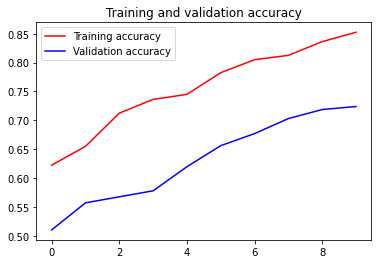

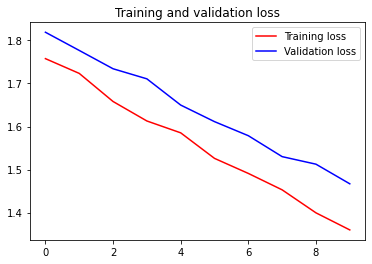

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
loss = model.evaluate(validation_generator, steps=10)

10/10 [==============================] - 71s 6s/step - loss: 1.4698 - accuracy: 0.7200


Saving daun jambu biji.jpg to daun jambu biji (1).jpg
Saving daun kari.jpg to daun kari (1).jpg
Saving daun mint.jpg to daun mint (1).jpg
Saving daun pepaya.jpg to daun pepaya (1).jpg
Saving daun sirih.jpg to daun sirih (1).jpg
Saving daun sirsak.jpg to daun sirsak (1).jpg
Saving daun-kemangi.jpg to daun-kemangi (1).jpg
Saving daun-kunyit.jpg to daun-kunyit (1).jpg
Saving lidah buaya.jpg to lidah buaya (1).jpg
Saving teh hijau.jpg to teh hijau (1).jpg


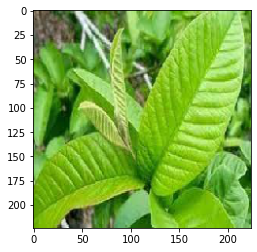

Daun Jambu Biji: 12.94%
Daun Kari: 8.91%
Daun Kemangi: 10.73%
Daun Kunyit: 13.67%
Daun Mint: 11.87%
Daun Pepaya: 5.57%
Daun Sirih: 11.53%
Daun Sirsak: 4.23%
Lidah Buaya: 3.86%
Teh Hijau: 16.69%


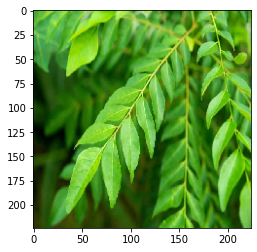

Daun Jambu Biji: 10.63%
Daun Kari: 11.84%
Daun Kemangi: 8.47%
Daun Kunyit: 16.18%
Daun Mint: 7.09%
Daun Pepaya: 10.69%
Daun Sirih: 9.31%
Daun Sirsak: 4.66%
Lidah Buaya: 8.94%
Teh Hijau: 12.20%


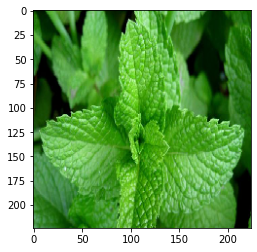

Daun Jambu Biji: 5.38%
Daun Kari: 2.18%
Daun Kemangi: 4.95%
Daun Kunyit: 9.01%
Daun Mint: 41.30%
Daun Pepaya: 2.69%
Daun Sirih: 17.37%
Daun Sirsak: 2.73%
Lidah Buaya: 6.47%
Teh Hijau: 7.92%


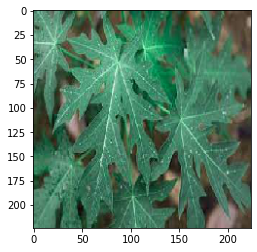

Daun Jambu Biji: 7.19%
Daun Kari: 7.84%
Daun Kemangi: 10.93%
Daun Kunyit: 7.64%
Daun Mint: 8.25%
Daun Pepaya: 16.89%
Daun Sirih: 11.74%
Daun Sirsak: 7.82%
Lidah Buaya: 7.70%
Teh Hijau: 13.99%


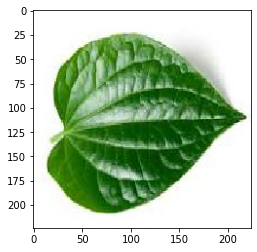

Daun Jambu Biji: 20.46%
Daun Kari: 5.48%
Daun Kemangi: 7.92%
Daun Kunyit: 9.74%
Daun Mint: 14.93%
Daun Pepaya: 4.30%
Daun Sirih: 20.94%
Daun Sirsak: 4.17%
Lidah Buaya: 5.64%
Teh Hijau: 6.42%


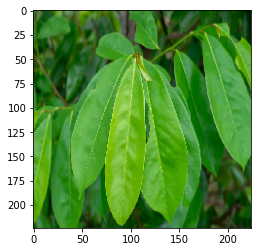

Daun Jambu Biji: 13.73%
Daun Kari: 9.57%
Daun Kemangi: 14.82%
Daun Kunyit: 16.75%
Daun Mint: 8.62%
Daun Pepaya: 7.79%
Daun Sirih: 10.72%
Daun Sirsak: 3.97%
Lidah Buaya: 5.03%
Teh Hijau: 9.00%


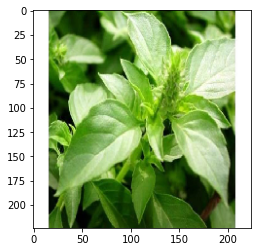

Daun Jambu Biji: 9.50%
Daun Kari: 4.73%
Daun Kemangi: 11.99%
Daun Kunyit: 15.58%
Daun Mint: 12.00%
Daun Pepaya: 8.94%
Daun Sirih: 15.29%
Daun Sirsak: 5.49%
Lidah Buaya: 8.13%
Teh Hijau: 8.35%


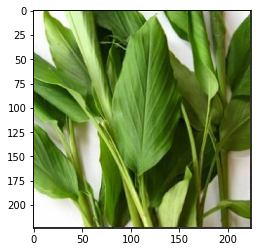

Daun Jambu Biji: 5.01%
Daun Kari: 6.85%
Daun Kemangi: 16.21%
Daun Kunyit: 11.35%
Daun Mint: 9.86%
Daun Pepaya: 11.18%
Daun Sirih: 8.68%
Daun Sirsak: 10.40%
Lidah Buaya: 6.88%
Teh Hijau: 13.59%


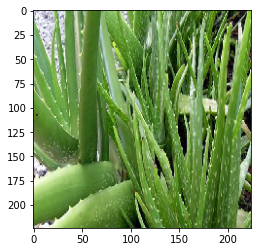

Daun Jambu Biji: 4.04%
Daun Kari: 4.21%
Daun Kemangi: 7.09%
Daun Kunyit: 5.55%
Daun Mint: 24.00%
Daun Pepaya: 11.52%
Daun Sirih: 11.52%
Daun Sirsak: 7.54%
Lidah Buaya: 10.38%
Teh Hijau: 14.15%


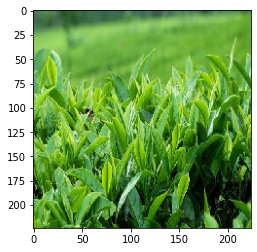

Daun Jambu Biji: 4.51%
Daun Kari: 4.09%
Daun Kemangi: 5.84%
Daun Kunyit: 8.45%
Daun Mint: 9.18%
Daun Pepaya: 15.99%
Daun Sirih: 8.47%
Daun Sirsak: 5.80%
Lidah Buaya: 8.52%
Teh Hijau: 29.14%


In [21]:
labels = train_generator.class_indices.keys()
uploaded = files.upload()

for paths in uploaded.keys():
 
  # predicting images
  path = paths
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))

In [22]:
saved_model_path = "/content/paranmo_transferlearning.h5"

# Save model h5
model.save(saved_model_path)

In [23]:
export_dir = "/content/"
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/assets


In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path("/content/paranmo_transferlearning_model.tflite")
tflite_model_file.write_bytes(tflite_model)